In [48]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_error as mse

train = pd.read_csv('/kaggle/input/playground-series-s3e8/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e8/test.csv')
sub = pd.read_csv('/kaggle/input/playground-series-s3e8/sample_submission.csv')
extra = pd.read_csv('/kaggle/input/gemstone-price-prediction/cubic_zirconia.csv')
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
extra.drop(columns=['Unnamed: 0'],inplace=True)
extra.dropna(inplace=True)

df = pd.concat([train,extra,test])
df.drop_duplicates(inplace=True)

In [51]:
def encoder(data):
    le = LabelEncoder()
    le.fit(data)
    return le.transform(data)    

def normal(data):
    transformer = Normalizer().fit(data) 
    return transformer.transform(data)

In [52]:
df['cut'] = encoder(df['cut'])
df['color'] = encoder(df['color'])
df['clarity'] = encoder(df['clarity'])

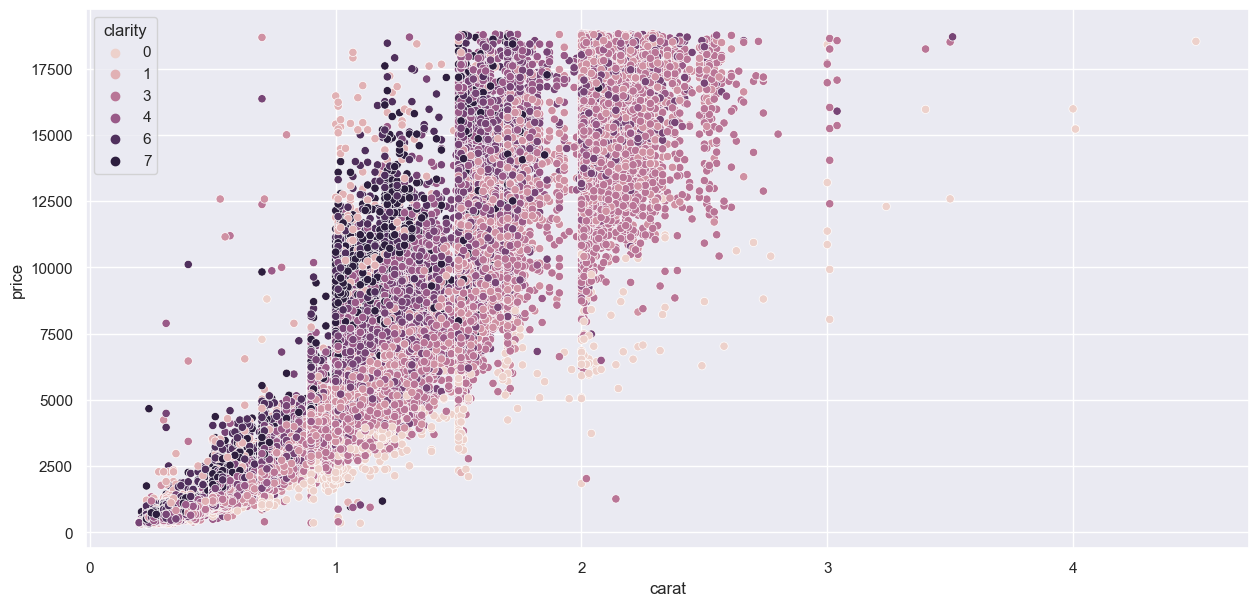

In [53]:
sns.set(rc={'figure.figsize':(15,7)})
sns.scatterplot(data=df, x="carat", y="price", hue="clarity");

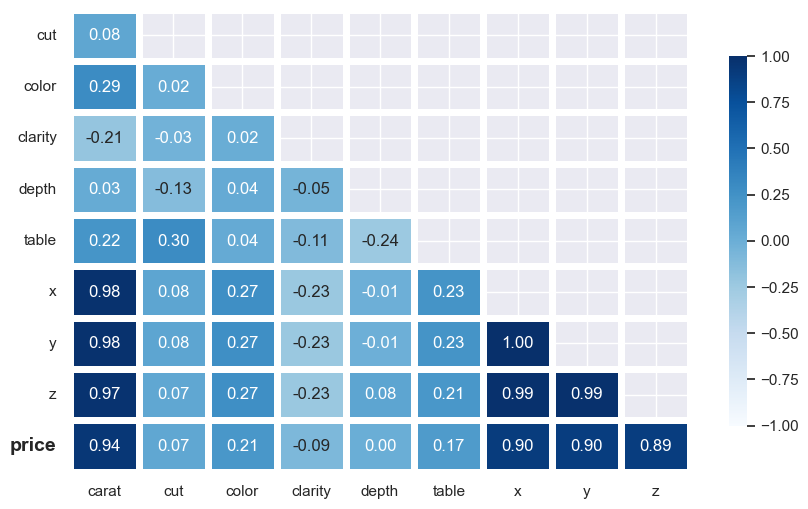

In [54]:
df_corr = df.corr()
fig, ax = plt.subplots(figsize=(10, 6))
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
sns.heatmap(corr, mask=mask, fmt=".2f", cmap='Blues',vmin=-1, vmax=1, annot=True, annot_kws={'fontsize': 12}, cbar_kws={"shrink": .8}, linewidths=5,)
plt.yticks(rotation=0)
plt.yticks()[-1][-1].set_fontsize(14)
plt.yticks()[-1][-1].set_fontweight('bold')
plt.show()

In [55]:
df.drop(df[(df['price'] > 10000) & (df['carat'] > 0)  & (df['carat'] < 1)].index, inplace=True)

In [56]:
df_train = df.iloc[:-len(test),:]
df_test = df.iloc[-len(test):,:]

X = df_train[['carat','x','y','z']]
y = df_train.price

X_test = df_test[['carat','x','y','z']]

In [57]:
std_ = StandardScaler()
mms_ = MinMaxScaler()
mas_ = MaxAbsScaler()
rbs_ = RobustScaler()
nml_ = Normalizer()

X_std = std_.fit_transform(X)
X_mms = mms_.fit_transform(X)
X_mas = mas_.fit_transform(X)
X_rbs = rbs_.fit_transform(X)
X_nml = nml_.fit_transform(X)

df_result = pd.DataFrame(columns=['model','scale','mse'])

def train_test(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.85,random_state=2023)
    return x_train, x_test, y_train, y_test

def train_model(x,y, model,n_model, scale):
    x_train, x_test, y_train, y_test = train_test(x,y)
    model.fit(x_train, y_train, verbose=0)
    pred = model.predict(x_test)
    new_ = {'model':str(n_model),'scale':scale,'mse':mse(pred, y_test)}
    return new_, model

In [58]:
xgb = XGBRegressor()

dic, xgb_model_std = train_model(X_std,y,xgb,'XGBRegressor','StandardScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, xgb_model_mms = train_model(X_mms,y,xgb,'XGBRegressor','MinMaxScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, xgb_model_mas = train_model(X_mas,y,xgb,'XGBRegressor','MaxAbsScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, xgb_model_rbs = train_model(X_rbs,y,xgb,'XGBRegressor','RobustScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, xgb_model_nml = train_model(X_nml,y,xgb,'XGBRegressor','Normalizer')
df_result = df_result.append(dic, ignore_index=True)

In [59]:
cat = CatBoostRegressor()

dic, cat_model_std = train_model(X_std,y,cat,'CatBoostRegressor','StandardScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, cat_model_mms = train_model(X_mms,y,cat,'CatBoostRegressor','MinMaxScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, cat_model_mas = train_model(X_mas,y,cat,'CatBoostRegressor','MaxAbsScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, cat_model_rbs = train_model(X_rbs,y,cat,'CatBoostRegressor','RobustScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, cat_model_nml = train_model(X_nml,y,cat,'CatBoostRegressor','Normalizer')
df_result = df_result.append(dic, ignore_index=True)

In [60]:
lgb = LGBMRegressor()

dic, lgb_model_std = train_model(X_std,y,cat,'LGBMRegressor','StandardScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, lgb_model_mms = train_model(X_mms,y,cat,'LGBMRegressor','MinMaxScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, lgb_model_mas = train_model(X_mas,y,cat,'LGBMRegressor','MaxAbsScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, lgb_model_rbs = train_model(X_rbs,y,cat,'LGBMRegressor','RobustScaler')
df_result = df_result.append(dic, ignore_index=True)

dic, lgb_model_nml = train_model(X_nml,y,cat,'LGBMRegressor','Normalizer')
df_result = df_result.append(dic, ignore_index=True)

In [61]:
df_result.sort_values(by='mse', ascending=True)

,model,scale,mse
5,CatBoostRegressor,StandardScaler,1.382974e+06
6,CatBoostRegressor,MinMaxScaler,1.382974e+06
7,CatBoostRegressor,MaxAbsScaler,1.382974e+06
8,CatBoostRegressor,RobustScaler,1.382974e+06
10,LGBMRegressor,StandardScaler,1.382974e+06
11,LGBMRegressor,MinMaxScaler,1.382974e+06
12,LGBMRegressor,MaxAbsScaler,1.382974e+06
13,LGBMRegressor,RobustScaler,1.382974e+06
2,XGBRegressor,MaxAbsScaler,1.396672e+06
1,XGBRegressor,MinMaxScaler,1.396693e+06


In [62]:
sub['price'] = cat_model_std.predict(X_test)
sub.to_csv('submission.csv',index=False)